# Importing Libraries


In [ ]:
import numpy as np
import os
from skimage.transform import resize
from matplotlib.pyplot import imread
import datetime
from PIL import Image
import os
from tensorflow.keras.utils import to_categorical


In [ ]:
!pip install scikit-image
!pip install opencv-python
!pip install mediapipe
import skimage
from skimage.io import imread
from skimage.transform import resize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.8 MB 1.3 MB/s 


We set the random seed so that the results don't vary drastically.

In [ ]:
import matplotlib.pyplot as plt
import random as random
from tensorflow.keras.utils import to_categorical
from keras import backend as K
import tensorflow as tf
import pathlib
import glob
import cv2
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers,regularizers


In [ ]:
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip -u "/content/drive/MyDrive/Project_data.zip" -d "/content/drive/MyDrive/Project_data"

In [ ]:
image_dir_train = pathlib.Path("/content/drive/MyDrive/Project_data/Project_data/train")
image_dir_test = pathlib.Path('/content/drive/MyDrive/Project_data/Project_data/val')
source_path          = "/content/drive/MyDrive/Project_data/Project_data/"

In [ ]:
# image_count_train = len(list(image_dir_train.glob('*/*.png')))
# print(image_count_train)
# image_count_test = len(list(image_dir_test.glob('*/*.png')))
# print(image_count_test)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
train_doc = np.random.permutation(open(source_path+'train.csv').readlines())
val_doc = np.random.permutation(open(source_path+'val.csv').readlines())
batch_size = 39
num_imges=5
num_epochs=50
image_shape = (160,160,3)
input_shape=[num_imges,160,160,3]     #tensor

train_path = "/content/drive/MyDrive/Project_data/Project_data/train"
test_path = '/content/drive/MyDrive/Project_data/Project_data/val'
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

print('# Epochs =', num_epochs)
print('# Training sequences =', num_train_sequences)
print("# Input Shape:",input_shape)

# Epochs = 50
# Training sequences = 663
# Input Shape: [5, 160, 160, 3]


In [ ]:
print("Train data:",len(train_doc))
print("Test data:",len(val_doc))

Train data: 663
Test data: 100


#Visualising Data

In [ ]:
%matplotlib inline

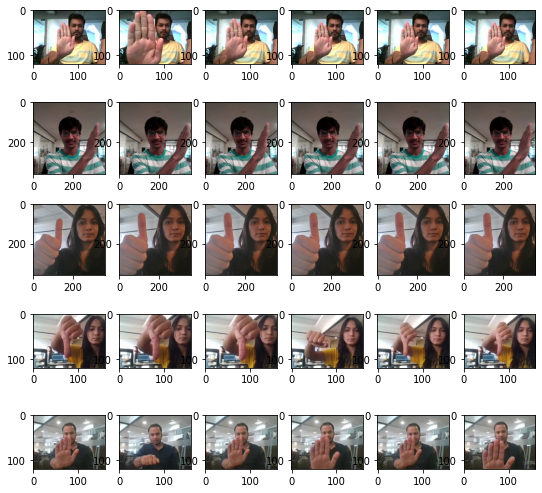

In [ ]:
t = np.random.permutation(train_doc)
num_of_people=5
frames       =10
img_list=[]
img_list1=[]
fig, ax = plt.subplots(nrows=num_of_people,ncols=6,figsize=(9,9))
for i in range(0,num_of_people):
    random_x=(i+1)*5
    imgs = os.listdir(source_path+ "train/"+t[random_x].split(';')[0]+"/")
    for j in range(0,frames):
       image = imread(source_path+'train/'+ t[random_x].strip().split(';')[0]+'/'+imgs[j])
       img_list1.append(image)
       if j<6:
          ax[i,j].imshow(image[:,:,:])
    img_list.append(image)

plt.show()       

### Image Preprocessing

...........Two Different Image size before/after crop operation...........


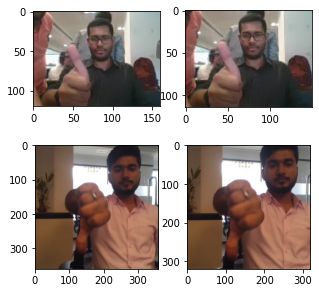

In [ ]:
t = np.random.permutation(train_doc)
num_of_people=15

fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(5,5))
for i in range(0,num_of_people):
    random_x=(i+1)*5
    imgs = os.listdir(source_path+ "train/"+t[random_x].split(';')[0]+"/")
    image = imread(source_path+'train/'+ t[random_x].strip().split(';')[0]+'/'+imgs[j])
    if image.shape[1]==360:
        image10=image
    if image.shape[1]==160:
        image01=image
      
print('...........Two Different Image size before/after crop operation...........')        
ax[0,0].imshow(image01[:,:,:])
ax[1,0].imshow(image10[:,:,:])
image100 = image01[5:155,5:155]
image101 = image10[20:-20,20:-20]
ax[0,1].imshow(image100[:,:,:])
ax[1,1].imshow(image101[:,:,:])
plt.show() 

....Original image following range for rotation used in augmentation Image size before/after crop...........


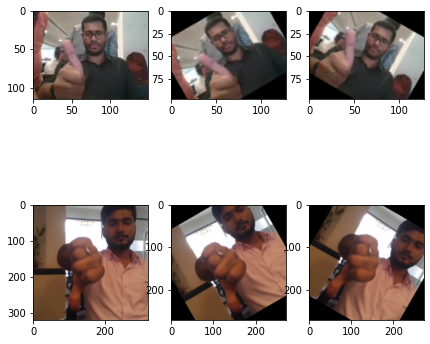

In [ ]:
from skimage import transform
transformed_img36=transform.rotate(image100,angle=30,)
transformed_img36=transform.rescale(transformed_img36,0.85, anti_aliasing=True)
transformed_img16=transform.rotate(image101,angle=30)
transformed_img16=transform.rescale(transformed_img16,0.85, anti_aliasing=True)
transformed_img36_1=transform.rotate(image100,angle=-30)

transformed_img36_1=transform.rescale(transformed_img36_1,0.85, anti_aliasing=True)
transformed_img16_1=transform.rotate(image101,angle=-30)
transformed_img16_1=transform.rescale(transformed_img16_1,0.85, anti_aliasing=True)
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(7,7), )
print('....Original image following range for rotation used in augmentation Image size before/after crop...........')        
ax[0,0].imshow(image100[:,:,:])
ax[0,1].imshow(transformed_img36[:,:,:])
ax[0,2].imshow(transformed_img36_1[:,:,:])
ax[1,0].imshow(image101[:,:,:])
ax[1,1].imshow(transformed_img16[:,:,:])
ax[1,2].imshow(transformed_img16_1[:,:,:])

plt.show() 

###Image augmentation -Skin mask

Detecting Skin on single video images


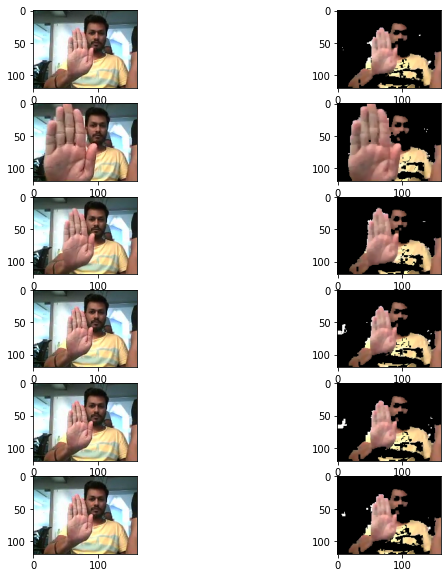

In [ ]:
print("Detecting Skin on single video images")
fig, ax = plt.subplots(nrows=6,ncols=2,figsize=(10,10))
kernel = (1/16)*np.ones((3,3)) # kernel for morphological transformations 

test1,test2,test3,test4,test5,test6=img_list1[0],img_list1[1],img_list1[2],img_list1[3],img_list1[4],img_list1[5],

image44 = preprocess_image(test1,kernel)
image45 = preprocess_image(test2,kernel)
image46 = preprocess_image(test3,kernel)
image47 = preprocess_image(test4,kernel)
image48 = preprocess_image(test5,kernel)
image49 = preprocess_image(test6,kernel)
# image50 = preprocess_image(test6,kernel)


ax[0,0].imshow(test1[:,:,:])
ax[1,0].imshow(test2[:,:,:])
ax[2,0].imshow(test3[:,:,:])
ax[3,0].imshow(test4[:,:,:])
ax[4,0].imshow(test5[:,:,:])
ax[5,0].imshow(test6[:,:,:])

ax[0,1].imshow(image44[:,:,:])
ax[1,1].imshow(image45[:,:,:])
ax[2,1].imshow(image46[:,:,:])
ax[3,1].imshow(image47[:,:,:])
ax[4,1].imshow(image48[:,:,:])
ax[5,1].imshow(image49[:,:,:])
plt.show()

In [ ]:
###Searching for low intensity image
dim_image_index=[]
for index,i in enumerate(img_list1):
  if np.mean(i)<102:
      dim_image_index.append(index)

.........Capturing skin in low light images by rescaling intensity..............


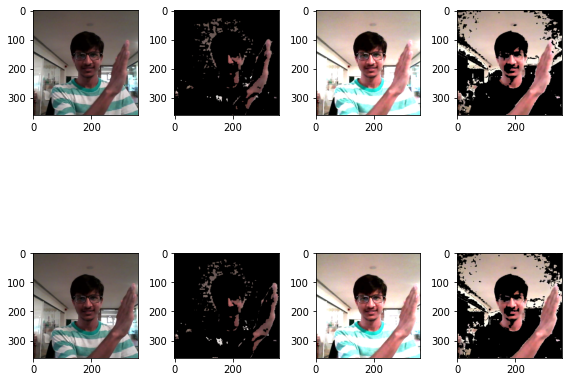

In [ ]:
image100=img_list1[dim_image_index[0]]
image101=img_list1[dim_image_index[1]]
##Detecting sking on original and rescaled image

log_exposure=1.5
image100_1=exposure.rescale_intensity(image100,in_range=tuple(np.percentile(image100, (0, 75.5))))
image101_1=exposure.rescale_intensity(image101,in_range=tuple(np.percentile(image101, (0, 75.5))))
# Logarithmic
image100_2=exposure.adjust_log(image100, log_exposure)
image101_2=exposure.adjust_log(image101, log_exposure)
kernel = (1/16)*np.ones((3,3)) # kernel for morphological transformations 
preprocess_100= preprocess_image(image100,kernel)
preprocess_100_1= preprocess_image(image100_1,kernel)
preprocess_100_2= preprocess_image(image100_2,kernel)
preprocess_101= preprocess_image(image101,kernel)
preprocess_101_1= preprocess_image(image101_1,kernel)
preprocess_101_2= preprocess_image(image101_2,kernel)
fig, ax = plt.subplots(nrows=2,ncols=4,figsize=(8,8))
print(".........Capturing skin in low light images by rescaling intensity..............")
ax[0,0].imshow(image100[:,:,:])
ax[0,1].imshow(preprocess_100[:,:,:])
ax[0,2].imshow(image100_1[:,:,:])
ax[0,3].imshow(preprocess_100_1[:,:,:])

ax[1,0].imshow(image101[:,:,:])
ax[1,1].imshow(preprocess_101[:,:,:])
ax[1,2].imshow(image101_1[:,:,:])
ax[1,3].imshow(preprocess_101_1[:,:,:])

plt.tight_layout()
plt.show()

##Image Preprocessing


In [ ]:
# image augmentation 

# Since, gestures are performed by humans, masking the background and only detecting the skin can help in learning faster

# The below function is skin tone filter
def skin_rules(R_Frame, G_Frame, B_Frame) : 
    BRG_Max = np.maximum.reduce([B_Frame, G_Frame, R_Frame])
    BRG_Min = np.minimum.reduce([B_Frame, G_Frame, R_Frame])
    #at uniform daylight, The skin colour illumination's rule is defined by the following equation :
    Rule_1 = np.logical_and.reduce([R_Frame > 95, G_Frame > 60, B_Frame > 20 ,
                                    BRG_Max - BRG_Min > 10,
                                    abs(R_Frame - G_Frame) > 15, 
                                    R_Frame > G_Frame, R_Frame > B_Frame])
    #the skin colour under flashlight or daylight lateral illumination rule is defined by the following equation :
    Rule_2 = np.logical_and.reduce([R_Frame > 220, G_Frame > 210, B_Frame > 170,
                         abs(R_Frame - G_Frame) <= 12, R_Frame > B_Frame, G_Frame > B_Frame])
    #Rule_1 U Rule_2
    RGB_Rule = np.logical_or(Rule_1, Rule_2)
    return RGB_Rule

# The below function detects skin and removes other scene elements.
def detect_skin(img) : 
       mask = skin_rules(img[:,:,0], img[:,:,1], img[:,:,2])
       img[:,:,0] = img[:,:,0] * mask 

       img[:,:,1] = img[:,:,1] * mask
       img[:,:,2] = img[:,:,2] * mask
       return img

def erode(img,kernel) : 
    img_erode = np.zeros_like(img)

    img_erode[:,:,0] = cv2.erode(img[:,:,0],kernel)
    img_erode[:,:,1] = cv2.erode(img[:,:,1],kernel)
    img_erode[:,:,2] = cv2.erode(img[:,:,2],kernel)

    return img_erode

def dilate(img,kernel) : 
    img_dilate = np.zeros_like(img)
    img_dilate[:,:,0] = cv2.dilate(img[:,:,0],kernel)
    img_dilate[:,:,1] = cv2.dilate(img[:,:,1],kernel)
    img_dilate[:,:,2] = cv2.dilate(img[:,:,2],kernel)

    return img_dilate

def rescale_intensity_(img):
    return(exposure.rescale_intensity(img,in_range=tuple(np.percentile(img, (0, 75.5)))))

def closing(img,kernel) : 
    return dilate(erode(img,kernel),kernel)

def opening(img,kernel) : 
    return erode(dilate(img,kernel),kernel)


def open_close(img,kernel) : 
    return closing(opening(img,kernel),kernel)

def close_open(img,kernel) : 
    return closing(opening(img,kernel),kernel)

# opencv normalisation is used to prevent any math overflows.
def cv_normalise(img) : 
    img_new = np.zeros_like(img)
    cv2.normalize(img, img_new , 0,1, cv2.NORM_MINMAX)

    assert round(np.max(img_new),1) == 1, 'Normalisation error'+ str(np.max(img_new)) 
    assert round(np.min(img_new),1) == 0 ,'Normalisation error'+ str(np.min(img_new))

    return img_new


# opening and then closing is performed to remove noise from images and then skin is detected
def preprocess_image(img,kernel) : 

    img = open_close(img,kernel)
    if np.mean(img)<102:
       img=rescale_intensity_(img)
    img = detect_skin(img)

    return img

## Generator


In [ ]:
import time
def generator(source_path, folder_list, batch_size,augment=True):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0, 30, 3))
    while True:
        
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size

        for batch in range(num_batches): # we iterate over the number of batches
            time.sleep(0.1)
            batch_data = np.zeros((batch_size,len(img_idx),160,160,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                #print(batch,folder,(folder + (batch*batch_size)))
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    # Although images are of two different sizes, they both have some part more informative and some less
                    # Cropping the center part in and extra part out alongwith skin detection can be good for training

                    # Similarly, 360x360 images could be center cropped since the gesture information is contained in the center.
                    if image.shape[0] == 120 : 
                        image = image[2:-2,5:145]
                    if image.shape[0] == 360 : 
                        image = image[120:240,120:240]   

                    # Both images are brought to the same dimension and then resized to 160x160
                    image = resize(image, (160,160))
                        
                   # if augmentation is true, randomly mask scenes from a few images.
                    if augment:
                       if idx in list(np.random.randint(0,29,5)): 
                        kernel = (1/16)*np.ones((3,3)) # kernel for morphological transformations 
                        image = preprocess_image(image,kernel)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255.0
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255.0
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255.0
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].split(';')[2])] = 1
                
                #batch_labels = tf.keras.utils.to_categorical(batch_labels, 5)
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
                    # Remaining data after integral batch_numbers 
        
        remainder_size = len(folder_list) % batch_size
        remainder_folders = t[-1*(remainder_size + 1) : -1 ]
        
        assert remainder_size == len(range(-1*(remainder_size + 1) , -1)) , 'Take care of the remainder folders '
        
        # The last remaining image folders are still loaded onto a tensor of batch_size. It has been noted that this doesnot affect performance.
        batch_data = np.zeros((batch_size,len(img_idx),*image_shape)) 
        batch_labels = np.zeros((batch_size,5))
        
        
        for folder in range(remainder_size): 
            
            imgs = os.listdir(source_path+'/'+ remainder_folders[folder].split(';')[0])
            
            
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ remainder_folders[folder].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                
                if image.shape[0] == 120 : 
                    image = image[2:-2,5:145]
                if image.shape[0] == 360 : 
                    image = image[120:240,120:240]
                
                image = resize(image, (160,160))
                
                if augment :
                  if idx in list(np.random.randint(0,29,5)) :
                        kernel = (1/16)*np.ones((4,4)) # kernel for morphological transformations 
                        image = preprocess_image(image,kernel)
                    

                batch_data[folder,idx,:,:,0] = cv_normalise(image[:,:,0])
                batch_data[folder,idx,:,:,1] = cv_normalise(image[:,:,1])
                batch_data[folder,idx,:,:,2] = cv_normalise(image[:,:,2])

            
            batch_labels[folder, int(remainder_folders[folder].strip().split(';')[2])] = 1
        
        # write the code for the remaining data points which are left after full batches



In [ ]:
def plot_history(history):   
   val_acc = history.history['val_categorical_accuracy']
   acc = history.history['categorical_accuracy']
   loss = history.history['loss']
   val_loss = history.history['val_loss']

   epochs_range = range(epochs)
 
   plt.figure(figsize=(8, 8))
   plt.subplot(1, 2, 1)
   plt.plot(epochs_range, acc, label='Training Accuracy')
   plt.plot(epochs_range, val_acc, label='Validation Accuracy')
   plt.legend(loc='lower right')
   plt.title('Training and Validation Accuracy')
 
   plt.subplot(1, 2, 2)
   plt.plot(epochs_range, loss, label='Training Loss')
   plt.plot(epochs_range, val_loss, label='Validation Loss')
   plt.legend(loc='upper right')
   plt.title('Training and Validation Loss')
   return plt.show()

# Model 



In [ ]:
#Hyper Parameters
batch_size = 3
num_imges=5
num_epochs=20
input_shape=[num_imges,120,160,3]

In [ ]:
#Creating Model
model = Sequential()

model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape,padding="same",kernel_regularizer=regularizers.l2(l=0.01)))
model.add(Conv3D(64, kernel_size=(2, 2, 2), activation='relu',padding="same",kernel_regularizer=regularizers.l2(l=0.01)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(128, kernel_size=(2, 2, 2), activation='relu',padding="same"))
model.add(MaxPooling3D(pool_size=(2, 2, 2),padding='same'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax') )

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
#Optimising model
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    0.1, #starter_learning_rate,
    1200, #decay_steps,
    0.00001,#end_learning_rate,
    power=0.1) 
model.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=learning_rate_fn),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 3, 120, 160, 32)   2624      
                                                                 
 conv3d_4 (Conv3D)           (None, 3, 120, 160, 64)   16448     
                                                                 
 batch_normalization_1 (Batc  (None, 3, 120, 160, 64)  256       
 hNormalization)                                                 
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 1, 60, 80, 64)    0         
 3D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 1, 60, 80, 64)     0         
                                                                 
 conv3d_5 (Conv3D)           (None, 1, 60, 80, 128)   

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(test_path, val_doc, batch_size)

In [ ]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/Project_data/train ; batch size = 3
Epoch 1/20
221/221 [==============================] - 874s 4s/step - loss: 2.4714 - categorical_accuracy: 0.2805 - val_loss: 1.9667 - val_categorical_accuracy: 0.3627
Epoch 2/20
221/221 [==============================] - 39s 179ms/step - loss: 1.6743 - categorical_accuracy: 0.4676 - val_loss: 1.7127 - val_categorical_accuracy: 0.5882
Epoch 3/20
221/221 [==============================] - 38s 173ms/step - loss: 1.3412 - categorical_accuracy: 0.6033 - val_loss: 1.3905 - val_categorical_accuracy: 0.6765
Epoch 4/20
221/221 [==============================] - 38s 173ms/step - loss: 1.0219 - categorical_accuracy: 0.7496 - val_loss: 1.3668 - val_categorical_accuracy: 0.5980
Epoch 5/20
221/221 [==============================] - 38s 173ms/step - loss: 0.9875 - categorical_accuracy: 0.7768 - val_loss: 1.2507 - val_categorical_accuracy: 0.7255
Epoch 6/20
221/221 [==============================] - 38s 173ms/step -

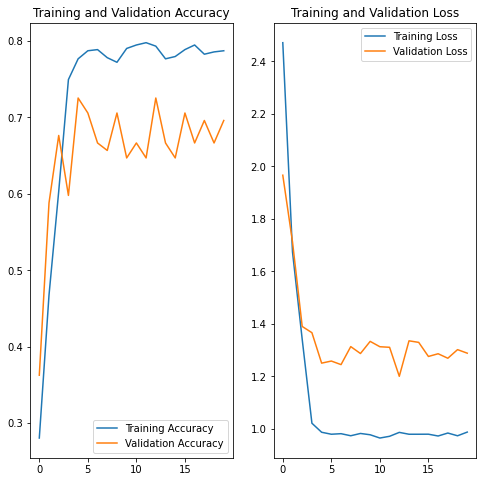

In [ ]:
#Visualising loss and accuracy
epochs=num_epochs 
plot_history(history) 